# Language Translation using RNN(Recurrent Neural Network)

In [0]:
!wget http://www.manythings.org/anki/deu-eng.zip 

--2019-11-22 19:52:50--  http://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 2606:4700:30::6818:6dc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7612057 (7.3M) [application/zip]
Saving to: ‘deu-eng.zip’

deu-eng.zip         100%[===================>]   7.26M  24.6MB/s    in 0.3s    

2019-11-22 19:52:51 (24.6 MB/s) - ‘deu-eng.zip’ saved [7612057/7612057]



In [0]:
!unzip deu-eng.zip

Archive:  deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              


In [0]:
file=open("deu.txt", mode="rt", encoding="utf-8")
data=file.read()

In [0]:
def to_lines(text):
  sent=text.strip().split("\n")
  sent=[r.split("\t") for r in sent]
  return sent              
                

In [0]:
import numpy as np
deu_eng=to_lines(data)
print(deu_eng)
deu_eng=np.asarray(deu_eng)
deu_eng[10]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



array(['Go on.', 'Mach weiter.',
       'CC-BY 2.0 (France) Attribution: tatoeba.org #2230774 (CK) & #6625701 (Felixjp)'],
      dtype='<U537')

In [0]:
deu_eng[10].shape

(3,)

In [0]:
deu_eng=deu_eng[:50000,:]

In [0]:
import string
deu_eng[:,0]=[s.translate(str.maketrans('','',string.punctuation)).lower() for s in deu_eng[:,0]]
deu_eng[:,1]=[s.translate(str.maketrans('','',string.punctuation)).lower() for s in deu_eng[:,1]]

In [0]:
deu_eng

array([['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ['run', 'lauf',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)'],
       ...,
       ['i wholeheartedly agree', 'ich stimme rückhaltlos zu',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1488273 (Spamster) & #1693172 (al_ex_an_der)'],
       ['i will always love you', 'ich werde dich immer lieben',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #853146 (piksea) & #395302 (xtofu80)'],
       ['i will be back by nine', 'um neun bin ich wieder zurück',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #72281 (CK) & #345033 (lilygilder)']],
      dtype='<U537')

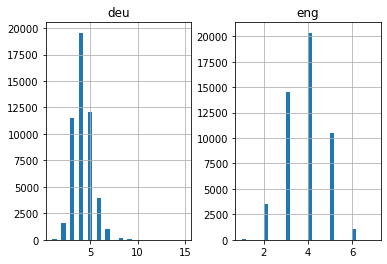

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [0]:
from keras.preprocessing.text import Tokenizer

def tokenization(lines):
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer


In [0]:
eng_tokenizer=tokenization(deu_eng[:,0])
deu_tokenizer=tokenization(deu_eng[:,1])

eng_vocab_size=len(eng_tokenizer.word_index) +1
deu_vocab_size=len(deu_tokenizer.word_index) +1

print(len(eng_tokenizer.word_index) +1)
print(len(deu_tokenizer.word_index) +1)

6361
10597


In [0]:
from keras.preprocessing.sequence import pad_sequences

def encode_sequence(tokenizer, length, lines):
  seq=tokenizer.texts_to_sequences(lines)
  seq=pad_sequences(seq, maxlen=length, padding='post')
  return seq

In [0]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(deu_eng, test_size=0.2, random_state=12)


In [0]:
train.shape

(40000, 3)

In [0]:
trainX=encode_sequence(deu_tokenizer, 8, train[:,1])
trainY=encode_sequence(eng_tokenizer, 8, train[:,0])

testX=encode_sequence(deu_tokenizer, 8, test[:,1])
testY=encode_sequence(eng_tokenizer, 8, test[:,0])

print(trainX.shape,trainY.shape)
print(testX.shape,testY.shape)




(40000, 8) (40000, 8)
(10000, 8) (10000, 8)


In [0]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,RepeatVector,Embedding
from keras import optimizers

In [0]:
model=Sequential()
model.add(Embedding(deu_vocab_size, 512, input_length=8))
model.add(LSTM(512))
model.add(RepeatVector(8))
model.add(LSTM(512, return_sequences=True))
model.add(Dense(eng_vocab_size, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizers.RMSprop(lr=0.001) )

In [0]:
from keras.callbacks import ModelCheckpoint
checkpoints=ModelCheckpoint("model.h1", monitor="val_loss", verbose=1, save_best_only=True,mode="min")
history=model.fit(trainX,trainY.reshape(40000,8,1), epochs=30, batch_size=512, validation_split=0.2, callbacks=[checkpoints], verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 32000 samples, validate on 8000 samples
Epoch 1/30





32000/32000 [==============================] - 21s 656us/step - loss: 3.3951 - val_loss: 2.9894

Epoch 00001: val_loss improved from inf to 2.98938, saving model to model.h1
Epoch 2/30
32000/32000 [==============================] - 15s 454us/step - loss: 2.8681 - val_loss: 2.8641

Epoch 00002: val_loss improved from 2.98938 to 2.86410, saving model to model.h1
Epoch 3/30
32000/32000 [==============================] - 15s 455us/step - loss: 2.6997 - val_loss: 2.7186

Epoch 00003: val_loss improved from 2.86410 to 2.71865, saving model to model.h1
Epoch 4/30
32000/32000 [==============================] - 15s 458us/step - loss: 2.5701 - val_loss: 2.6100

Epoch 00004: val_loss improved from 2.71865 to 2.60997, saving model to model.h1
Epoch 5/30
32000/32000 [==============================] - 15s 458us/step - loss: 2.4503 - val_los

In [0]:
from keras.models import load_model
model=load_model("model.h1")
preds=model.predict_classes(testX)

In [0]:
print(preds)

[[  3 102   7 ...   0   0   0]
 [  2 157 680 ...   0   0   0]
 [ 12 356 356 ...   0   0   0]
 ...
 [  1   4   5 ...   0   0   0]
 [ 54  18   3 ...   0   0   0]
 [ 39  27  20 ...   0   0   0]]


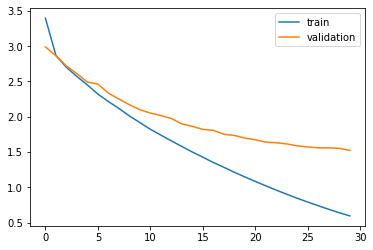

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [0]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [0]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [0]:
# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
5261,did you love tom,did you see tom
39,he lives in yokohama,he lives in kyoto
5672,im good at this,im good at this
9456,when do you need it,when did you need it
5826,this hat cost me 10,this hat my me
8710,tom is depraved,tom is skittish
2283,tom was special,tom was a
1977,ive offended you,i watched you
8796,dont go yet,dont be alone
7894,everybody loves my cat,she took my hat
